In [33]:
import pandas as pd
import numpy as np
from time import strftime
import sys

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

%matplotlib inline

random_state = 42
np.random.seed(random_state)


In [34]:
data = pd.read_pickle("data_forecast.pickle")[["DATETIME","GVKEY","IND_CODE","VALUE","MOMENTUM","RET3"]]
data.head()


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET3
0,1963-01-31,1010,25,1.443624,0.126256,0.077724
1,1963-01-31,1040,6,0.448922,-0.477048,0.041148
2,1963-01-31,1043,41,0.255952,-0.390406,-0.056931
3,1963-01-31,1045,40,1.383475,-0.130926,0.082269
4,1963-01-31,1075,31,0.476919,-0.187948,-0.002032


In [6]:
uniquedates = sorted(data["DATETIME"].unique())
uniquedates[:10]

[numpy.datetime64('1963-01-31T00:00:00.000000000'),
 numpy.datetime64('1963-02-28T00:00:00.000000000'),
 numpy.datetime64('1963-03-31T00:00:00.000000000'),
 numpy.datetime64('1963-04-30T00:00:00.000000000'),
 numpy.datetime64('1963-05-31T00:00:00.000000000'),
 numpy.datetime64('1963-06-30T00:00:00.000000000'),
 numpy.datetime64('1963-07-31T00:00:00.000000000'),
 numpy.datetime64('1963-08-31T00:00:00.000000000'),
 numpy.datetime64('1963-09-30T00:00:00.000000000'),
 numpy.datetime64('1963-10-31T00:00:00.000000000')]

In [7]:
num_buckets = 5

def bucket_df_by_col(df, col, num_buckets=num_buckets):
    # compute decile buckets for df.col
    # assign new column col_RANK containing decile bucket for each row
    newcol = col + "_RANK"
    # add a random small num to prevent bucket collisions
    df["tempcol"]=df[col] + np.random.uniform(0,0.0000001,len(df))
    # bucket tempcol into num_buckets quantiles
    vals = pd.qcut(df["tempcol"], num_buckets, labels=False)
    df[newcol] = vals
    #df = df.assign(c=col.values)
    return df

col = "MOMENTUM_RANK"
# Assume we put 1/3 port each month in bucket for 3 months
DIVIDE_BY = 3

def perf_by_bucket(df, col, rank, perfcol="RET3"):
    perf = df.loc[df[col]==rank][["DATETIME", col, perfcol]]\
        .groupby("DATETIME")\
        .mean()\
        .reset_index()
    return perf

def perf_bucket_by_col(data, col, nbuckets=5):

    col_rank = col + "_RANK"

    dflist = [bucket_df_by_col(data[data["DATETIME"]==d], col, nbuckets) for d in uniquedates]
    datanew= pd.concat(dflist)

    reportdict = {'Label': [],
                  'Annualized return' : [],
                  'Annualized volatility' : []}

    for i in range(nbuckets):
        
        tempdf = perf_by_bucket(datanew, col_rank, i, perfcol="RET3")
        # 1-month signal
        tempdf["RET1P"] = 1 + (tempdf["RET3"]/DIVIDE_BY)
        tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()

        lastval = list(tempdf["CUMPERF"])[-1]

        annret = (lastval**(1/55)-1)*100
        vol = tempdf["CUMPERF"].pct_change().std() * np.sqrt(12)

        plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

        reportdict['Label'].append("Quintile %d " % (i))
        reportdict['Annualized return'].append(annret)
        reportdict['Annualized volatility'].append(vol)
    
    plt.legend();
    plt.title(col)
    plt.show()

    return pd.DataFrame(reportdict)


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


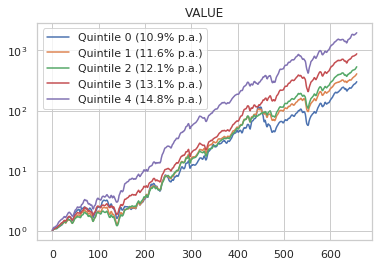

,Label,Annualized return,Annualized volatility
0,Quintile 0,10.940988,0.125537
1,Quintile 1,11.555962,0.107313
2,Quintile 2,12.102128,0.099629
3,Quintile 3,13.121210,0.095582
4,Quintile 4,14.792321,0.099480


In [8]:
col = "VALUE"
perf_bucket_by_col(data, col)


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


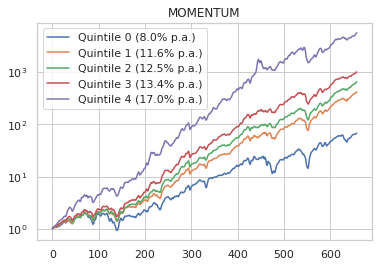

,Label,Annualized return,Annualized volatility
0,Quintile 0,7.978570,0.129891
1,Quintile 1,11.603500,0.098936
2,Quintile 2,12.517160,0.091538
3,Quintile 3,13.400726,0.093942
4,Quintile 4,17.007959,0.123248


In [9]:
col = "MOMENTUM"
perf_bucket_by_col(data, col)


In [35]:
# make return buckets
bucket_df_by_col(data, "RET3", num_buckets=num_buckets)
   

,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET3,tempcol,RET3_RANK
0,1963-01-31,1010,25,1.443624,0.126256,0.077724,0.077724,3
1,1963-01-31,1040,6,0.448922,-0.477048,0.041148,0.041148,2
2,1963-01-31,1043,41,0.255952,-0.390406,-0.056931,-0.056931,1
3,1963-01-31,1045,40,1.383475,-0.130926,0.082269,0.082269,3
4,1963-01-31,1075,31,0.476919,-0.187948,-0.002032,-0.002032,2
5,1963-01-31,1078,41,0.423057,0.016883,0.167320,0.167320,4
6,1963-01-31,1209,14,0.456838,-0.169348,-0.009172,-0.009172,1
7,1963-01-31,1215,14,0.795584,-0.106268,0.085797,0.085797,3
8,1963-01-31,1221,14,1.499520,0.388141,0.051627,0.051627,2
9,1963-01-31,1243,19,1.072439,-0.158415,0.175573,0.175573,4


In [36]:
#data=data[["DATETIME","GVKEY","IND_CODE","VALUE","MOMENTUM","RET3_RANK"]]
data=data[["DATETIME","GVKEY","VALUE","MOMENTUM","RET3_RANK","RET3"]]
data.head()

,DATETIME,GVKEY,VALUE,MOMENTUM,RET3_RANK,RET3
0,1963-01-31,1010,1.443624,0.126256,3,0.077724
1,1963-01-31,1040,0.448922,-0.477048,2,0.041148
2,1963-01-31,1043,0.255952,-0.390406,1,-0.056931
3,1963-01-31,1045,1.383475,-0.130926,3,0.082269
4,1963-01-31,1075,0.476919,-0.187948,2,-0.002032


In [30]:
#data = pd.concat((data, pd.get_dummies(data["IND_CODE"], prefix="IND_CODE", drop_first=True)), axis=1)

In [31]:
data[['DATETIME', 'GVKEY', 
      'IND_CODE_1', 'IND_CODE_2', 'IND_CODE_3', 'IND_CODE_4', 'IND_CODE_5',
      'IND_CODE_6', 'IND_CODE_7', 'IND_CODE_8', 'IND_CODE_9', 'IND_CODE_10',
      'IND_CODE_11', 'IND_CODE_12', 'IND_CODE_13', 'IND_CODE_14',
      'IND_CODE_15', 'IND_CODE_16', 'IND_CODE_17', 'IND_CODE_18',
      'IND_CODE_19', 'IND_CODE_20', 'IND_CODE_21', 'IND_CODE_22',
      'IND_CODE_23', 'IND_CODE_24', 'IND_CODE_25', 'IND_CODE_26',
      'IND_CODE_27', 'IND_CODE_28', 'IND_CODE_29', 'IND_CODE_30',
      'IND_CODE_31', 'IND_CODE_32', 'IND_CODE_33', 'IND_CODE_34',
      'IND_CODE_35', 'IND_CODE_36', 'IND_CODE_37', 'IND_CODE_38',
      'IND_CODE_39', 'IND_CODE_40', 'IND_CODE_41', 'IND_CODE_42',
      'IND_CODE_43', 'IND_CODE_44', 'IND_CODE_45', 'IND_CODE_46',
      'IND_CODE_47', 'IND_CODE_48', 
      'VALUE', 'MOMENTUM', 'RET3_RANK']
    ].head()


,DATETIME,GVKEY,IND_CODE_1,IND_CODE_2,IND_CODE_3,IND_CODE_4,IND_CODE_5,IND_CODE_6,IND_CODE_7,IND_CODE_8,...,IND_CODE_42,IND_CODE_43,IND_CODE_44,IND_CODE_45,IND_CODE_46,IND_CODE_47,IND_CODE_48,VALUE,MOMENTUM,RET3_RANK
0,1963-01-31,1010,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.443624,0.126256,3
1,1963-01-31,1040,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.448922,-0.477048,2
2,1963-01-31,1043,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.255952,-0.390406,1
3,1963-01-31,1045,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.383475,-0.130926,3
4,1963-01-31,1075,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.476919,-0.187948,2


In [15]:
FIRST_TRAIN_MONTHS=120

class BacktestModel():
    
    def __init__(self, 
                 df,
                 create_model=None,
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 fit_missing=None):

        # 1st column = dates
        # 2nd column = gvkeys
        self.data = df.copy()
        self.data.sort_values(["DATETIME", "GVKEY"], inplace=True)
        self.data.reset_index(inplace=True)
        self.uniquedates = self.data.groupby("DATETIME")["index"].first().reset_index()
        self.uniquedatelist = list(self.uniquedates["index"])
        self.uniquedatedict = dict(zip(self.uniquedates["DATETIME"], 
                                       self.uniquedates["index"]))
        # last column = target
        self.y = df.iloc[:,-1]
        
        # middle = features
        self.X = df.iloc[:,2:-1]
        self.Xrows, self.Xcols = self.X.shape
        
        # create predictions
        self.P = np.zeros(self.y.shape)
        
        self.Xscale = self.X.copy()
        self.yscale = self.y.copy()

        if scaler:
            self.Xscale = scaler().fit_transform(self.Xscale)
            #            self.yscale = scaler().fit_transform(self.yscale.values.reshape(self.Xrows,1))
        
        self.create_model = create_model
        self.startindex = startindex
        self.fit_missing = fit_missing
        
    def fit_predict(self, train_months, predict_months=1, verbose=False):
        """for backtest, train model  
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain months
        train_stop_index = self.uniquedatelist[train_months]
        if verbose:
            print("Training months 0:%d, indexes 0:%d" % (train_months-1, train_stop_index-1))
        X_fit = self.Xscale[:train_stop_index]  # e.g. 0:120
        y_fit = self.yscale[:train_stop_index]

        # train model
        self.model = self.create_model()
        self.model.fit(X_fit, y_fit)

        # predict npredict months (but don't exceed bounds)
        if train_months+predict_months > len(self.uniquedatelist)-1:
            predict_stop_index = len(self.Xscale)
        else:
            predict_stop_index = self.uniquedatelist[train_months+predict_months]
            
        if verbose:
            print("Predicting months %d:%d, indexes %d:%d" % (train_months, train_months+predict_months-1, 
                                                              train_stop_index, predict_stop_index-1))
        self.X_predict = self.Xscale[train_stop_index:predict_stop_index] # 121-122
        self.y_predict_proba = self.model.predict_proba(self.X_predict)
        self.y_predict = self.y_predict_proba.dot(np.matrix("0 ; 1; 2; 3; 4"))
        self.P[train_stop_index:predict_stop_index] = self.y_predict.reshape(self.y_predict.shape[0])
        return self.P
    
    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):
        """predict all months, pass either step (# months) or total # of splits"""
        print("%s Starting training" % (strftime("%H:%M:%S")))

        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, len(self.uniquedatelist), step))
            
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(len(self.uniquedatelist) - month_indexes[-1])
        
        if verbose:
            print ("Months: " + str(month_indexes))
            print ("Steps: " + str(steps))

        progress_i = 0
            
        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d months (%d:%d), storing predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict(month_index, forecast_rows, verbose=verbose)
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")    
        print("%s Finished" % (strftime("%H:%M:%S")))


In [38]:
def my_create_model():
    return LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000,
                              n_jobs=-1)

backtestmodel = BacktestModel(data[["DATETIME","GVKEY","VALUE","MOMENTUM","RET3_RANK"]],
                              create_model=my_create_model,
                              startindex=FIRST_TRAIN_MONTHS)
backtestmodel.gen_predictions(verbose=False)

16:49:33 Starting training
................................................................................
16:50:05 Still training step 80 of 538
................................................................................
16:50:53 Still training step 160 of 538
................................................................................
16:51:59 Still training step 240 of 538
................................................................................
16:53:28 Still training step 320 of 538
................................................................................
16:55:09 Still training step 400 of 538
................................................................................
16:57:04 Still training step 480 of 538
..........................................................
16:58:38 Finished


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

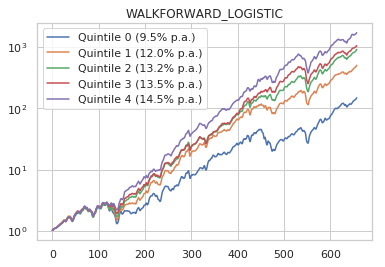

,Label,Annualized return,Annualized volatility
0,Quintile 0,9.512318,0.116184
1,Quintile 1,11.975713,0.104957
2,Quintile 2,13.199229,0.100985
3,Quintile 3,13.489067,0.097230
4,Quintile 4,14.491762,0.098967


In [39]:
col = "WALKFORWARD_LOGISTIC"
data[col] = backtestmodel.P
perf_bucket_by_col(data, col)

In [41]:
def my_create_model():
    return xgboost.sklearn.XGBClassifier(n_estimators=300, 
                                         max_depth=5, 
                                         subsample=0.5,
                                         learning_rate=0.6,
                                         n_jobs=-1
                                        )

backtestmodel = BacktestModel(data[["DATETIME","GVKEY","VALUE","MOMENTUM","RET3_RANK"]],
                              create_model=my_create_model,
                              startindex=FIRST_TRAIN_MONTHS)
backtestmodel.gen_predictions(verbose=False)

16:59:52 Starting training
................................................................................
17:20:38 Still training step 80 of 538
................................................................................
17:56:08 Still training step 160 of 538
................................................................................
18:47:35 Still training step 240 of 538
................................................................................
19:58:12 Still training step 320 of 538
................................................................................
21:34:02 Still training step 400 of 538
..............................................................................
23:32:09 Still training step 480 of 538
..........................................................
01:12:20 Finished


In [ ]:
col = "WALKFORWARD_XGB_CLASSIFIER"
data[col] = backtestmodel.P
perf_bucket_by_col(data, col)